In [1]:
import json
import geopandas as gpd
import ast
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from shapely import Polygon
import h3
import pandas as pd
from shapely import union_all


In [7]:
with open('task1/final_task1a_v2_gemini_responses.json') as f:
    gemini_responses = json.load(f)

with open('task1/final_task1a_v2_gpt_responses.json') as f:
    gpt_responses = json.load(f)

with open('../task_data/task1/task1_coordinates.json') as f:
    locs = json.load(f)

with open('../data/meta_data/iucn_species_names.json') as f:
    species_names = json.load(f)

In [8]:
species_ids = ["42888", "135104", "19284", "10717", "39579", "32944", "13270", "74831", "27123", "43339"]

In [10]:
with open('../data/gt_data/iucn_res_5.json') as f:
    data = json.load(f)

In [11]:
def get_h3_cell(lat, lng):
    return h3.geo_to_h3(lat, lng, 5)
iucn_dfs = []
for taxa in species_ids:
    data_df = pd.DataFrame(np.array(data['locs'])[data['taxa_presence'][str(taxa)]], columns=['lng','lat'])
    # Add H3 cell column
    data_df['h3index'] = data_df.apply(lambda row: get_h3_cell(row['lat'], row['lng']), axis=1)
    data_df['geometry'] = data_df.h3index.map(lambda cell: Polygon(h3.h3_to_geo_boundary(cell, True)))
    iucn_dfs.append(data_df)

In [12]:
def unify_shape(cells):
    # Perform union of geometries in the cells
    union_geometry = union_all(cells.geometry)
    # Intersect with the world geometry to ensure it's valid for display
    intersected_geometry = union_geometry.intersection(union_all(world.geometry))
    # Create a GeoDataFrame from the intersected geometry
    return gpd.GeoDataFrame(geometry=[intersected_geometry], crs="EPSG:4326")

/var/folders/pp/c6m9_85s5rd16hbzmflk4b9r0000gn/T/ipykernel_74074/3936667271.py:145: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


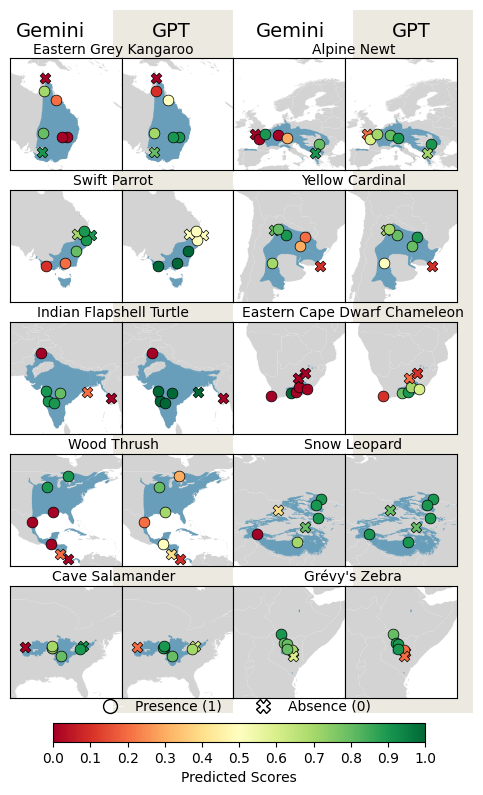

In [15]:
from matplotlib.patches import Rectangle

cmap = plt.cm.RdYlGn  # Use the RdYlGn colormap
world =gpd.read_file("../data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")

cm = 1/2.54  # centimeters in inches
fig,axs = plt.subplots(5,4,figsize=(12.2*cm, 17*cm))
padding=10

# Set titles for the 4 columns
fig.text(0.12, 1.01, 'Gemini', ha='center', fontsize=14)
fig.text(0.37, 1.01, 'GPT', ha='center', fontsize=14)
fig.text(0.62, 1.01, 'Gemini', ha='center', fontsize=14)
fig.text(0.87, 1.01, 'GPT', ha='center', fontsize=14)

# Add background color bands for columns 2 and 4
fig.patch.set_color('white')  # Set overall figure background to white

# Add colored rectangles to cover the 2nd and 4th columns
fig.patches.extend([
    Rectangle((0.25, 0), 0.25, 1.05, transform=fig.transFigure, color='#EBE9E0', zorder=-1, lw=0),  # Column 2
    Rectangle((0.75, 0), 0.25, 1.05, transform=fig.transFigure, color='#EBE9E0', zorder=-1, lw=0)   # Column 4
])

for i,species_id in enumerate(species_ids):
      # Get two consecutive axes for each species (left and right plot)
        ax_left = axs[i // 2, (i % 2) * 2]     # Left plot for this species
        ax_right = axs[i // 2, (i % 2) * 2 + 1]  # Right plot for this species

        # Plot for the left axis
        world.plot(ax=ax_left, color="lightgray")
        
        # For the right axis, simulate or plot something else if needed (e.g., presence/absence)
        world.plot(ax=ax_right, color="lightgray")
        
        # Set title on the middle above the two plots
        common_name = species_names[species_id]["common_name"]
        fig.text(
                0.25+(i%2)/2,  # Center horizontally across the figure
                0.985 - (i // 2)*0.197,  # Adjust the vertical position depending on the row
                common_name, 
                ha='center', fontsize=10,
        )

        #add plot code
        plot_df = unify_shape(iucn_dfs[i])
        plot_df.plot(ax=ax_left, color="#006BA2", alpha=0.5)
        plot_df.plot(ax=ax_right, color="#006BA2", alpha=0.5)

        response_left = gemini_responses[species_id]["response"]
        response_right = gpt_responses[species_id]["response"]

        loc = locs[species_id]

        start_index = response_left.find('[')
        end_index = response_left.rfind(']') + 1  # +1 to include the closing bracket
        preds_left = ast.literal_eval(response_left[start_index:end_index])
        preds_left = [float(i) for i in preds_left]


        start_index = response_right.find('[')
        end_index = response_right.rfind(']') + 1  # +1 to include the closing bracket
        preds_right = ast.literal_eval(response_right[start_index:end_index])
        preds_right = [float(i) for i in preds_right]


        # Extract locations and answers
        locations = loc['locations']
        correct_answers = loc['correct_answers']

        # Separate coordinates
        x_coords = [loc[0] for loc in locations]
        y_coords = [loc[1] for loc in locations]

        colors_left = cmap(preds_left)
        colors_right = cmap(preds_right)

        crop_xs = []
        crop_ys = []

        # Plot points with different markers based on correct_answers
        for i in range(len(correct_answers)):
                if correct_answers[i] == 1:
                        ax_left.scatter(x_coords[i], y_coords[i], color=colors_left[i], marker='o',s=60,edgecolor='black',linewidth=0.5, label='Correct (1)' if i == 0 else "")
                        ax_right.scatter(x_coords[i], y_coords[i], color=colors_right[i], marker='o',s=60,edgecolor='black',linewidth=0.5, label='Correct (1)' if i == 0 else "")
                        crop_xs.append(x_coords[i])
                        crop_ys.append(y_coords[i])
                else:
                        ax_left.scatter(x_coords[i], y_coords[i], color=colors_left[i], marker='X',s=60,edgecolor='black',linewidth=0.5, label='Incorrect (0)' if i == 0 else "")
                        ax_right.scatter(x_coords[i], y_coords[i], color=colors_right[i], marker='X',s=60,edgecolor='black',linewidth=0.5, label='Incorrect (0)' if i == 0 else "")

        # Calculate the range for x and y
        x_range = max(crop_xs) - min(crop_xs)
        y_range = max(crop_ys) - min(crop_ys)
        
        # Determine the larger range between x and y to make the plot square
        max_range = max(x_range, y_range)

        # Set limits for x and y so that they span the same range
        ax_left.set_xlim(min(crop_xs) - padding, min(crop_xs) + max_range + padding)
        ax_left.set_ylim(min(crop_ys) - padding, min(crop_ys) + max_range + padding)
        ax_right.set_xlim(min(crop_xs) - padding, min(crop_xs) + max_range + padding)
        ax_right.set_ylim(min(crop_ys) - padding, min(crop_ys) + max_range + padding)

        ax_left.set_aspect('equal')
        ax_right.set_aspect('equal')

        # Remove ticks and axis labels
        ax_left.set_xticks([])
        ax_left.set_yticks([])
        ax_left.set_xlabel('')
        ax_left.set_ylabel('')
        
        ax_right.set_xticks([])
        ax_right.set_yticks([])
        ax_right.set_xlabel('')
        ax_right.set_ylabel('')


# Create custom legend handles
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Presence (1)', 
            markerfacecolor='none', markeredgecolor='black', markersize=10, linewidth=0.5),
    Line2D([0], [0], marker='X', color='w', label='Absence (0)', 
            markerfacecolor='none', markeredgecolor='black', markersize=10, linewidth=0.5)
]

# Create a flat legend
fig.legend(
    handles=legend_elements, 
    loc='lower center', 
    bbox_to_anchor=(0.5, -0.01),  # Center the legend horizontally and position it a bit higher
    borderaxespad=0,  # No padding between legend border and axes
    ncol=2,  # Number of columns
    frameon=False,  # Disable the legend frame for a flatter look
)

# Create and add color bar
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_array([])  # Only needed for older versions of matplotlib
cbar = fig.colorbar(sm, ax=axs, orientation='horizontal', pad=0.15, location="bottom", anchor=(0,-1.75))  # Adjust pad as needed
cbar.set_label('Predicted Scores')
cbar.set_ticks(np.arange(0, 1.1, 0.1))  # Set ticks from 0 to 1 with step 0.1

plt.tight_layout()
plt.savefig('plots/task1_comparison.png', format='png', dpi=1200, bbox_inches='tight')
